In [23]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import gdown
import zipfile
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import inception_v3
from torch.utils.data import DataLoader
from scipy import linalg
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


**Pull in Dataset**

In [24]:
os.makedirs("celeba_gan", exist_ok=True)

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with zipfile.ZipFile(output, "r") as zipobj:
    zipobj.extractall("celeba_gan")

**Prepare and Visualize data**

Dataset size: 202599


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


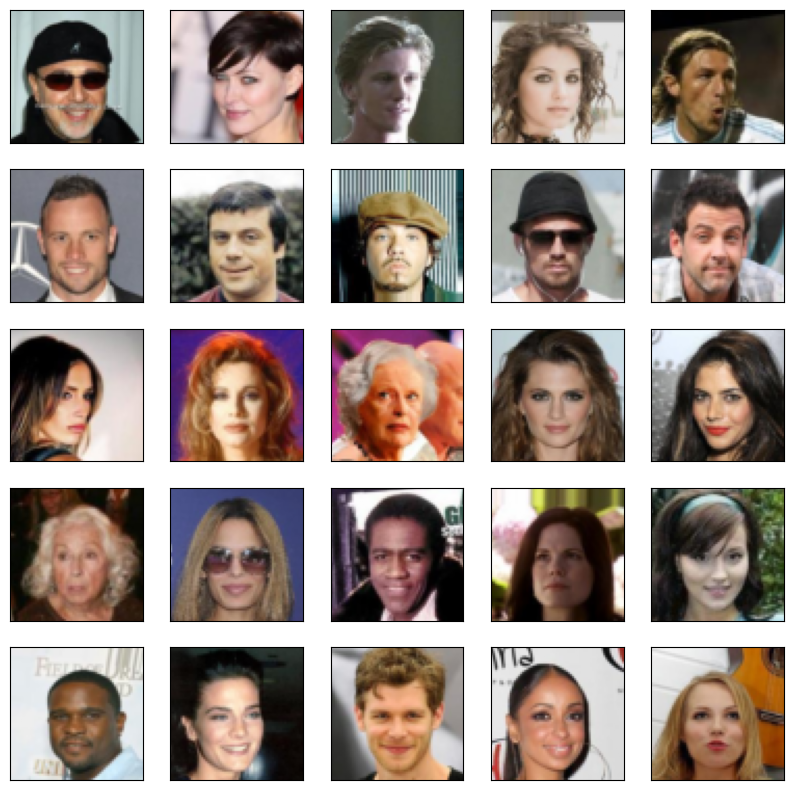

In [25]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # [-1, 1]
])

from torchvision.datasets import ImageFolder
dataset = ImageFolder(root="celeba_gan", transform=transform)

dataloader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

print(f"Dataset size: {len(dataset)}")

imgs, _ = next(iter(dataloader))
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = (imgs[i].permute(1, 2, 0).numpy() + 1) / 2.0
    plt.imshow(img)
plt.show()

**Load in models**

In [26]:
latent_dim = 128

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.main = nn.Sequential(
            # Input: latent_dim -> 8x8x256
            nn.Linear(latent_dim, 8 * 8 * 256),
            nn.Unflatten(1, (256, 8, 8)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # 16x16 -> 32x32
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # 32x32 -> 64x64 (Output Layer)
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # 64x64 → 32x32
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # 32x32 → 16x16
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 16x16 → 8x8
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # 8x8 → 4x4
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1),
            #nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

print("Generator parameters (M):", sum(p.numel() for p in generator.parameters())/1e6)
print("Discriminator parameters (M):", sum(p.numel() for p in discriminator.parameters())/1e6)

Generator parameters (M): 3.694211
Discriminator parameters (M): 2.766529


**Set up optimizers and Loss function**

In [27]:
g_optimizer = torch.optim.Adam(
    generator.parameters(),
    lr=0.0002,
    betas=(0.5, 0.999),
    fused=True
)
d_optimizer = torch.optim.Adam(
    discriminator.parameters(),
    lr=0.0002,
    betas=(0.5, 0.999),
    fused=True
)

criterion = torch.nn.BCEWithLogitsLoss()

**Save generates images to review**

In [28]:
@torch.no_grad()
def save_images(model, epoch, latent_dim, n=4):
    model.eval()
    noise = torch.randn(n * n, latent_dim, device=device)
    generated_images = model(noise)
    generated_images = (generated_images + 1) / 2.0

    plt.figure(figsize=(8, 8))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = generated_images[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
    plt.savefig("generated_image_epoch_%d.png" % epoch)
    plt.close()
    model.train()

**Training Loop**

In [32]:
def train_dcgan(epochs, dataloader, latent_dim):
    generator.train()
    discriminator.train()

    scaler = torch.cuda.amp.GradScaler()   # ✅ FIXED

    for epoch in range(epochs):
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for real_images, _ in pbar:
            batch_size = real_images.size(0)
            real_images = real_images.to(device, non_blocking=True)

            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # ---------------------
            # Train Discriminator
            # ---------------------
            d_optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast():   # ✅ FIXED
                real_output = discriminator(real_images)
                d_loss_real = criterion(real_output, real_labels)

                noise = torch.randn(batch_size, latent_dim, device=device)
                fake_images = generator(noise)
                fake_output = discriminator(fake_images.detach())
                d_loss_fake = criterion(fake_output, fake_labels)

                d_loss = d_loss_real + d_loss_fake

            scaler.scale(d_loss).backward()
            scaler.step(d_optimizer)
            scaler.update()

            # -----------------
            # Train Generator
            # -----------------
            g_optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast():   # ✅ FIXED
                noise = torch.randn(batch_size, latent_dim, device=device)
                fake_images = generator(noise)
                fake_output = discriminator(fake_images)
                g_loss = criterion(fake_output, real_labels)

            scaler.scale(g_loss).backward()
            scaler.step(g_optimizer)
            scaler.update()

            pbar.set_postfix({"D_loss": d_loss.item(), "G_loss": g_loss.item()})

        if (epoch + 1) % 5 == 0 or epoch == 0:
            save_images(generator, epoch + 1, latent_dim)

        print(f"Epoch {epoch+1}/{epochs} - D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")


In [ ]:
train_dcgan(epochs=50, dataloader=dataloader, latent_dim=latent_dim)
torch.save(generator.state_dict(), 'generator_final.pth')
torch.save(discriminator.state_dict(), 'discriminator_final.pth')
print("Generator and Discriminator models saved successfully!")

**Load in pretrained models**

In [1]:
# generator.load_state_dict(torch.load('model/generator_final.pth', map_location=device))
# discriminator.load_state_dict(torch.load('model/discriminator_final.pth', map_location=device))

# generator.eval()
# discriminator.eval()

# print("✓ Models loaded successfully!")
# print("Generator and Discriminator are ready for evaluation.")

**Evaluate models**

In [39]:
def evaluate_gan(generator, discriminator, dataloader, criterion, latent_dim, device):
    generator.eval()
    discriminator.eval()

    with torch.no_grad():
        real_images, _ = next(iter(dataloader))
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        real_output = discriminator(real_images)
        real_labels = torch.ones_like(real_output)
        d_loss_real = criterion(real_output, real_labels)

        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_images = generator(noise)
        fake_output_d = discriminator(fake_images.detach())
        fake_labels = torch.zeros_like(fake_output_d)
        d_loss_fake = criterion(fake_output_d, fake_labels)

        d_loss = d_loss_real + d_loss_fake

        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_images = generator(noise)
        fake_output_g = discriminator(fake_images)
        real_labels = torch.ones_like(fake_output_g)
        g_loss = criterion(fake_output_g, real_labels)

    generator.train()
    discriminator.train()

    return d_loss.item(), g_loss.item()


**Calculate FID**

In [38]:
class InceptionFID(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = inception_v3(weights="IMAGENET1K_V1", transform_input=False)
        self.model.fc = torch.nn.Identity()   # remove final classifier
        self.model.eval()

    @torch.no_grad()
    def forward(self, x):
        x = (x + 1) / 2
        x = F.interpolate(x, size=(299, 299), mode="bilinear", align_corners=False)

        return self.model(x)


def calculate_fid(real_images, fake_images, device="cuda"):
    real_images = real_images.to(device)
    fake_images = fake_images.to(device)

    inception = InceptionFID().to(device)

    with torch.no_grad():
        act_real = inception(real_images).cpu().numpy()
        act_fake = inception(fake_images).cpu().numpy()

    mu_r, mu_f = act_real.mean(axis=0), act_fake.mean(axis=0)
    sigma_r, sigma_f = np.cov(act_real, rowvar=False), np.cov(act_fake, rowvar=False)

    covmean, _ = linalg.sqrtm(sigma_r @ sigma_f, disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = np.sum((mu_r - mu_f)**2) + np.trace(
        sigma_r + sigma_f - 2 * covmean
    )
    return float(fid)

In [40]:
def compute_fid_score(generator, dataloader, latent_dim, num_samples=1000):
    generator.eval()

    real_imgs = []
    fake_imgs = []

    # Collect real images
    for imgs, _ in dataloader:
        real_imgs.append(imgs)
        if len(torch.cat(real_imgs)) >= num_samples:
            break

    real_imgs = torch.cat(real_imgs)[:num_samples]

    # Generate fake images
    noise = torch.randn(num_samples, latent_dim, device=device)
    with torch.no_grad():
        fake_imgs = generator(noise).cpu()

    # Compute FID
    fid = calculate_fid(real_imgs, fake_imgs, device=device)
    return fid

**Print out results**

In [42]:
d, g = evaluate_gan(generator, discriminator, dataloader, criterion, latent_dim, device)
print(f"D Loss: {d:.4f}, G Loss: {g:.4f}")

# Redefine calculate_fid to handle batches for Inception model
def calculate_fid(real_images, fake_images, device="cuda", inception_batch_size=64):
    # InceptionFID class is already defined in a previous cell (adbb057f), no need to redefine here
    inception = InceptionFID().to(device)

    # Process real images in batches
    act_real_list = []
    for i in range(0, real_images.size(0), inception_batch_size):
        batch = real_images[i:i + inception_batch_size]
        with torch.no_grad():
            act_real_list.append(inception(batch).cpu().numpy())
    act_real = np.concatenate(act_real_list, axis=0)

    # Process fake images in batches
    act_fake_list = []
    for i in range(0, fake_images.size(0), inception_batch_size):
        batch = fake_images[i:i + inception_batch_size]
        with torch.no_grad():
            act_fake_list.append(inception(batch).cpu().numpy())
    act_fake = np.concatenate(act_fake_list, axis=0)

    mu_r, mu_f = act_real.mean(axis=0), act_fake.mean(axis=0)
    sigma_r, sigma_f = np.cov(act_real, rowvar=False), np.cov(act_fake, rowvar=False)

    covmean, _ = linalg.sqrtm(sigma_r @ sigma_f, disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = np.sum((mu_r - mu_f)**2) + np.trace(
        sigma_r + sigma_f - 2 * covmean
    )
    return float(fid)

# Redefine compute_fid_score to use the batched calculate_fid and allow configuring batch size
def compute_fid_score(generator, dataloader, latent_dim, num_samples=500, inception_batch_size=64):
    generator.eval()

    real_imgs_list = []
    collected_samples = 0
    for imgs, _ in dataloader:
        real_imgs_list.append(imgs)
        collected_samples += imgs.size(0)
        if collected_samples >= num_samples:
            break
    real_imgs = torch.cat(real_imgs_list)[:num_samples]

    noise = torch.randn(num_samples, latent_dim, device=device)
    with torch.no_grad():
        fake_imgs = generator(noise).cpu()

    # Ensure both real and fake images are on the correct device before passing to calculate_fid
    real_imgs = real_imgs.to(device)
    fake_imgs = fake_imgs.to(device)

    fid = calculate_fid(real_imgs, fake_imgs, device=device, inception_batch_size=inception_batch_size)
    return fid

# Call the redefined compute_fid_score with updated parameters
fid_score = compute_fid_score(generator, dataloader, latent_dim, num_samples=500, inception_batch_size=64)
print("FID:", fid_score)


D Loss: 0.3063, G Loss: 4.6649


/tmp/ipython-input-3250571469.py:28: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma_r @ sigma_f, disp=False)


FID: 72.0842298717066
